In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considére l'équation de transport avec diffusion non linéaire suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = \epsilon \frac{\partial}{\partial x}\left(\left| \frac{\partial u}{\partial x} \right|^p \frac{\partial u}{\partial x} \right) \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [40]:
" **** Solutions initiales proposées **** "


@njit#(cache=True)
def u0_Creno(x,N):
    # Fonction indicatrice pour une condition initiale creno
    if  x >= 0.1 and x <= 0.2:
        return 10.
    else:
        return 0.

@njit#(cache=True)
def u0_Gauss(x,N):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin((N-1) * (L - l) * np.pi * x / (L - l))


" **** Le flux exact **** "

@njit#(cache=True)
def F(u, a):
    # Flux exact
    return a * u


" **** Les flux numériques proposés **** "

@njit#(cache=True)
def Rusanov(ug, ud, a, dx, dt):
    # Flux numérique Rusanov
    return 0.5 * (F(ug, a) + F(ud, a)) - a * (ud - ug)

@njit#(cache=True)
def Rusanov2(ug, ud, a, dx, dt):
    # Deuxième version du flux numérique Rusanov
    return 0.5 * (F(ug, a) + F(ud, a) - a * (ud - ug))

@njit#(cache=True)
def Roe(ug, ud, a, dx, dt):
    # Flux numérique Roe
    if a >= 0:
        return F(ug, a)
    else:
        return F(ud, a)

@njit#(cache=True)
def LF(ug, ud, a, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * (F(ug, a) + F(ud, a) - (dx / dt) * (ud - ug))

@njit#(cache=True)
def LFM(ug, ud, a, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * (F(ug, a) + F(ud, a) - 0.5 * (dx / dt) * (ud - ug))

@njit(cache=True)
def LW(ug, ud, a, dx, dt):
    # Flux numérique Lax-Wendroff
    return 0.5 * (F(ug, a) + F(ud, a) - (dt / dx) * (a ** 2) * (ud - ug))

@njit#(cache=True)
def VFD(ug, ud, a, dx, dt):
    # Flux numérique volume finis decentré
    if a > 0:
        return F(ug, a)
    else:
        return F(ud, a)
    
    
@njit#(cache=True)
def departure(dt, alpha, X, a):
    aux = 1.0
    eps = 1e-9

    x0 = 0.5 * (X[:-1] + X[1:])
    xmp = x0
    kit = 0

    while aux > eps:
        x1 = xmp - dt * alpha * a
        aux = np.max(np.abs(x1 - x0))

        x0 = x1
        kit += 1

    return x0, kit
@njit#(cache=True)
def FvcFlux(N, X, alpha, dt, u, a):
    F = np.zeros(N - 1)
    up = np.zeros(N - 1)
    
    # Characteristics foot
    x0, _ = departure(dt, alpha, X, a)

    # Interpolation procedure
    ui = np.interp(x0, X, u)

    # Predictor stage
    for i in range(N - 1):
        up[i] = ui[i]

    # Corrector stage
    for i in range(N - 1):
        F[i] = a * up[i]

    return F

@njit
def VFC(U0, T,  N, alpha , dx):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    temps = 0
    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**p)
        max_diff = np.max(absolute_differences)
        
        if epsilon != 0 and a!=0:
            dt  = CFL /((2*a*alpha)/dx + 2 * np.abs(epsilon*max_diff)/(dx**2))
        else:
            if epsilon == 0:
                dt    = CFL*(dx/(2*a*alpha))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon*max_diff)

        dt = min(dt, T - temps)
        temps += dt
        for i in range(1,N-1):
            X1 = X[i-1:i+2]
            u  = Un[i-1:i+2]
            F  = FvcFlux(3, X1, alpha, dt, u, a)
            Fg = F[0]
            Fd = F[1]
            FDd = (np.abs((Un[i+1]-Un[i])/dx))**p * (Un[i+1]-Un[i])/dx
            FDg = (np.abs((Un[i]-Un[i-1])/dx))**p * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * dt/dx * (FDd-FDg)

        Unp1[0] = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]
        Un = Unp1.copy()
    return Un
@njit#(cache=True)
def Solver(U0, T, l, L, CFL, a, epsilon, N, scheme, p):

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LW
    elif scheme == 4:
        flux = VFD
   
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**p)
        max_diff = np.max(absolute_differences)
        
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(a)/dx + 2 * np.abs(epsilon*max_diff)/(dx**2))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon*max_diff)

        dt = min(dt, T - temps)
        temps += dt
        
        
        for i in range(1, N - 1):
            
            Fd = flux ( Un[i], Un[i + 1], a, dx, dt )
            Fg = flux ( Un[i - 1], Un[i], a, dx, dt )
            
            FDd = (np.abs((Un[i+1]-Un[i])/dx))**p * (Un[i+1]-Un[i])/dx
            FDg = (np.abs((Un[i]-Un[i-1])/dx))**p * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * dt/dx * (FDd-FDg)

        Unp1[0] = 0#Unp1[1]
        Unp1[N - 1] = 0#Unp1[N - 2]

        Un[:] = Unp1[:]

    return Un


################################################################################################################
" **** Initialisation des paramètres **** "
T        =  1/6
l        =  0
L        =  1
a        =  2
epsilon  =  0.0001
N        =  101
CFL      =  0.75
alpha    =  1
X        =  np.linspace(l,L,N)
U0       =  np.array([u0_Creno(x,N) for x in X])
p        =  2

dx = (L - l) / (N - 1)
f = {}

" **** Calcul des solutions approchées **** "
fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1,  ("LW",3):1, ("VFD",4):1}

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  Solver  (U0 , T, l, L, CFL, a, epsilon, N, i[1],p)   
    

U_VFC = VFC( U0, T,  N, alpha, dx)

f['VFC'] = U_VFC

/tmp/ipykernel_56080/4092649178.py:177: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1, N - 1):


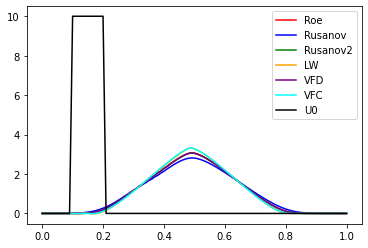

In [44]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":1,  "LW":1, "VFD":1, "VFC":1 }

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']
symbols = ['-', '-.', '-.', '+', '-', 'o-', '*', '^']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])

#plt.plot(X, U_VFC, '-c',  label='VFC')
plt.plot(X, U0, '-k',  label='U0')

#plt.xlim([0.4, 0.6])  
#plt.ylim([1, 4])  

plt.legend()
plt.pause(0.1)


In [37]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm


{'Roe': 10.551625551252847,
 'Rusanov': 10.22995875673874,
 'Rusanov2': 10.551625551252847,
 'LW': 10.8582274022231,
 'VFD': 10.551625551252847,
 'VFC': 10.895906529585117}